# Dynamic weighting of vibe-coded and researcher distributions
This notebook demonstrates how to blend the coefficients produced in `converge.py`
with a GPU-friendly pipeline that lets you dynamically reweight the vibe-generated
distribution against the researcher-curated distribution.

In [1]:
import math
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
import torch
print("Torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print("Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))
print("Architectures:", torch.cuda.get_arch_list())


Torch: 2.10.0.dev20251109+cu128
CUDA: 12.8
Available: True
Device: NVIDIA GeForce RTX 5070
Architectures: ['sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'sm_100', 'sm_120']


## Define the base distributions
We mirror the functions in `converge.py` so they can execute on the selected device.

In [3]:
torch.set_default_dtype(torch.float64)

def gaussian(x, mu=0.0, sigma=1.0, amplitude=1.0):
    coef = amplitude / (sigma * torch.sqrt(torch.tensor(2.0 * math.pi, device=x.device, dtype=x.dtype)))
    return coef * torch.exp(-0.5 * ((x - mu) / sigma) ** 2)

def target_func(x):
    return 3.0 * gaussian(x)

def start_func(x):
    return 0.25 * torch.ones_like(x)

def vibe_func(x):
    return gaussian(x + 1.0)

def taylor_coeffs(func, degree, a=0.0, radius=0.5, device=device):
    m = degree + 1
    if radius <= 0:
        radius = 0.5
    i = torch.arange(m, device=device, dtype=torch.get_default_dtype())
    angles = (2 * i + 1) * math.pi / (2 * m)
    x_nodes = torch.tensor(a, device=device) + radius * torch.cos(angles)
    y = func(x_nodes)
    vand = torch.vander(x_nodes - a, N=m, increasing=True)
    lstsq = torch.linalg.lstsq(vand, y.unsqueeze(-1))
    return lstsq.solution.squeeze(-1)

def poly_eval(coeffs, x, a=0.0):
    powers = torch.vander(x - a, N=coeffs.shape[-1], increasing=True)
    return powers @ coeffs

degree = 12
a = 0.0
x = torch.linspace(-5, 5, 400, device=device)

coeffs_target = taylor_coeffs(target_func, degree, a=a)
coeffs_start = taylor_coeffs(start_func, degree, a=a)
coeffs_vibe = taylor_coeffs(vibe_func, degree, a=a)

## Build a dynamic weighting schedule
We let the vibe distribution dominate early, then gradually hand control to the
researcher distribution while fading out the historical start coefficients.

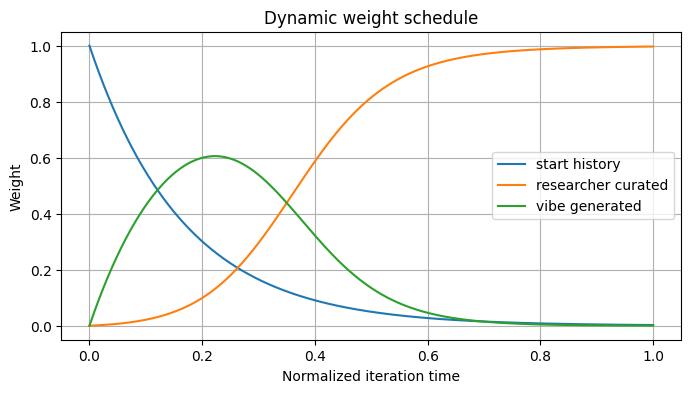

In [4]:
steps = 1000
times = torch.linspace(0.0, 1.0, steps + 1, device=device)

def researcher_weight(t, midpoint=0.35, sharpness=12.0):
    return torch.sigmoid(sharpness * (t - midpoint))

def vibe_weight(t):
    return 1.0 - researcher_weight(t)

def start_weight(t, decay=6.0):
    return torch.exp(-decay * t)

w_start = start_weight(times)
w_researcher = (1.0 - w_start) * researcher_weight(times)
w_vibe = (1.0 - w_start) * vibe_weight(times)
normalizer = w_start + w_researcher + w_vibe
w_start /= normalizer
w_researcher /= normalizer
w_vibe /= normalizer

weights = torch.stack([w_start, w_researcher, w_vibe], dim=-1)
weights_cpu = weights.detach().cpu().numpy()
plt.figure(figsize=(8, 4))
plt.plot(times.cpu(), weights_cpu[:, 0], label='start history')
plt.plot(times.cpu(), weights_cpu[:, 1], label='researcher curated')
plt.plot(times.cpu(), weights_cpu[:, 2], label='vibe generated')
plt.title('Dynamic weight schedule')
plt.xlabel('Normalized iteration time')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.show()

## Iterate coefficient updates on the GPU
We keep snapshots of the coefficients at regular intervals for visualization.

In [5]:
coeff_stack = torch.stack([coeffs_start, coeffs_target, coeffs_vibe], dim=0)

checkpoint_interval = 50
checkpoints = []
for idx, (ws, wr, wv) in enumerate(weights):
    blended = ws * coeffs_start + wr * coeffs_target + wv * coeffs_vibe
    if idx % checkpoint_interval == 0 or idx == steps:
        checkpoints.append(blended.detach().clone())

final_coeffs = checkpoints[-1]

## Visualize the interpolation trajectory
We evaluate the saved coefficients and overlay them with the original distributions.

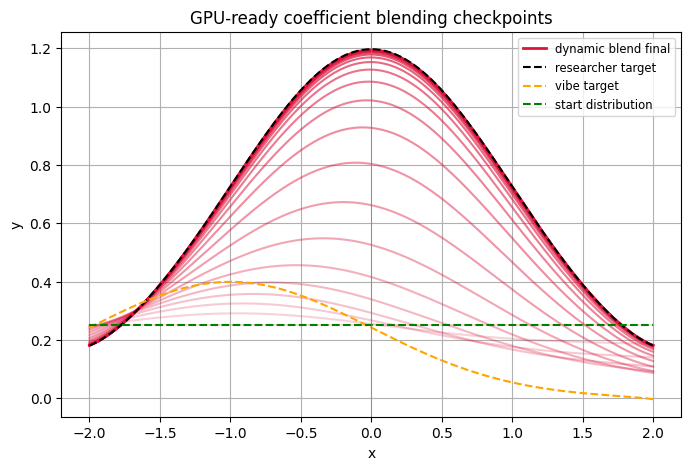

In [6]:
x_focus = torch.linspace(-2, 2, 400, device=device)
target_curve = poly_eval(coeffs_target, x_focus, a=a).detach().cpu().numpy()
start_curve = poly_eval(coeffs_start, x_focus, a=a).detach().cpu().numpy()
vibe_curve = poly_eval(coeffs_vibe, x_focus, a=a).detach().cpu().numpy()

plt.figure(figsize=(8, 5))
num = len(checkpoints)
for idx, coeffs in enumerate(checkpoints):
    alpha = 0.15 + 0.75 * (idx / max(1, num - 1))
    curve = poly_eval(coeffs, x_focus, a=a).detach().cpu().numpy()
    plt.plot(x_focus.cpu(), curve, color='crimson', alpha=alpha)

final_curve = poly_eval(final_coeffs, x_focus, a=a).detach().cpu().numpy()
plt.plot(x_focus.cpu(), final_curve, color='crimson', linewidth=2, label='dynamic blend final')
plt.plot(x_focus.cpu(), target_curve, color='black', linestyle='--', label='researcher target')
plt.plot(x_focus.cpu(), vibe_curve, color='orange', linestyle='--', label='vibe target')
plt.plot(x_focus.cpu(), start_curve, color='green', linestyle='--', label='start distribution')
plt.axvline(a, color='gray', linewidth=0.5)
plt.title('GPU-ready coefficient blending checkpoints')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()

## Export the final coefficients (optional)
You can feed these coefficients back into downstream components or serialize them
for later use.

In [7]:
final_coeffs_cpu = final_coeffs.detach().cpu()
print('Final coefficients:')
print(final_coeffs_cpu)

Final coefficients:
tensor([ 1.1941e+00, -9.8858e-05, -5.9669e-01,  3.2953e-05,  1.4916e-01,
        -4.9429e-06, -2.4860e-02,  3.9230e-07,  3.1073e-03, -7.7119e-09,
        -3.1029e-04, -2.0145e-09,  2.4439e-05])
